In [ ]:
import pandas as pd
import random
import wikipedia as wp
from wikipedia.exceptions import DisambiguationError, PageError
import networkx as nx
import matplotlib.pyplot as plt
from langsmith import Client
from langchain_core.tracers.context import tracing_v2_enabled
import os

In [ ]:


# Add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "KG Project"

client = Client()

In [ ]:
class RelationshipGenerator():
    """Generates relationships between terms, based on Wikipedia links"""
    def __init__(self):
        """Links are directional, start + end, they should also have a weight"""
        self.links = [] # list of tuples (start, end, weight)
    
    def scan(self, start=1, repeat=0):
        """Start scanning from a specific word, or from internal database

        Args:
            start (str): the term to start searching from, can be None to let
                algorithm decide where to start
            repeat (int): the number of times to repeat the scan
        """
        try:
            if start in [l[0] for l in self.links]:
                raise Exception(f"Already scanned {start}")
            
            term_search = True if start is not None else False

            # If a start isn't defined, we should find one
            if start is None:
                try:
                    start = self.find_starting_point()
                    print(f"Starting from {start}")
                except:
                    pass
            
            # Scan the starting point specified for links
            print(f"Scanning page {start}")
            # Fetch the page through the wikipedia API
            page = wp.page(start)
            links = list(set(page.links))
            # Ignore some uninteresting terms
            links = [l for l in links if not self.ignore_term(l)]

            # Add links to database
            pages = []
            link_weights = []
            for link in links:
                weight = self.weight_link(page, link)
                link_weights.append(weight)
            
            link_weights = [w / max(link_weights) for w in link_weights]

            for i, link in enumerate(links):
                self.links.append([start, link.lower(), link_weights[i] + 2 * int(term_search)]) # 3 works pretty well
            
            # Print some data to the user on progress
            explored_nodes = set([l[0] for l in self.links])
            explored_nodes_count = len(explored_nodes)
            total_nodes = set([l[1] for l in self.links])
            total_nodes_count = len(total_nodes)
            new_nodes = [l.lower() for l in links if l not in total_nodes]
            new_nodes_count = len(new_nodes)
            print(f"New nodes added: {new_nodes_count}, Total Nodes: {total_nodes_count}, Explored Nodes: {explored_nodes_count}")
        except (DisambiguationError, PageError):
            # This happens if the page has disambiguation or doesn't exist
            # We just ignore the page for now, could improve this
            pass #self.links.append([start, "DISAMBIGUATION", 0])
    
    def get_pages(self, start=1, repeat=0):

        global df_
        global data

        # Scan the starting point specified for links
        print(f"Scanning page {start}")
        # Fetch the page through the wikipedia API
        page = wp.page(start)
        links = list(set(page.links)) #[0:20] # Limit to 20 links
        # Ignore some uninteresting terms
        links = [l for l in links if not self.ignore_term(l)]

        # Add links, weights and pages to database
        pages = []
        link_weights = []
        for link in links:
            try:
                weight = self.weight_link(page, link)
                link_weights.append(weight)
                pages.append(wp.page(link))
                print(wp.page(link).content[0:20])
            except:
                pass
        # This may create an assymetric dictionary, so we will transform it 
        # into a valid dictionary to create a dataframe
        data = {
            "link": links,
            "link_weights": link_weights,
            "pages": pages
        }

        # Create the DataFrame outside the loop
        max_length = max(len(v) for v in data.values())

        # Pad shorter lists with NaN values
        padded_dict = {key: value + [float('nan')] * (max_length - len(value)) for key, value in data.items()}

        # Create the DataFrame
        df = pd.DataFrame.from_dict(padded_dict, orient='index')
        df_ = df.transpose()

        # Normalize link weights
        df_["link_weights"] = df_["link_weights"] / df_["link_weights"].max()

        return df_
    
    def find_starting_point(self):
        """Find the best place to start when no input is given"""
        # Need some links to work with
        if len(self.links) == 0:
            raise Exception("Unable to start, no start defined or existing links")
        
        # Get top terms 
        res = self.rank_terms()
        sorted_links = list(zip(res.index, res.values))
        all_starts = set([l[0] for l in self.links])

        # Remove identifiers (these are on many Wikipedia pages)
        all_starts = [l for l in all_starts if '(identifier)' not in l]

        # Iterate over the top links, until we find a new one
        for i in range(len(sorted_links)):
            if sorted_links[i][0] not in all_starts and len(sorted_links[i][0]) > 0:
                return sorted_links[i][0]
        
        # no link found
        raise Exception("No starting point found within links")
        return

    @staticmethod
    def weight_link(page, link):
        """Weight an outgoing link for a given source page

        Args:
            page (obj):
            link (str): the outgoing link of interest

        Returns:
            (float): the weight, between 0 and 1
        """
        weight = 0.1

        link_counts = page.content.lower().count(link.lower())
        weight += link_counts

        if link.lower() in page.content.lower():
            weight += 3
        print(f"Weight for {link}: {weight}")
        return weight

    def get_database(self):
        return sorted(self.links, key=lambda x: -x[2])

    def rank_terms(self, with_start=False):
        # We can use graph theory here
        
        df = pd.DataFrame(self.links, columns=["start", "end", "weight"])

        if with_start:
            df = df.append(df.rename(columns={"end": "start", "start": "end"}))
        return df.groupby("end").weight.sum().sort_values(ascending=False)

    def get_key_terms(self, n=20):
        return "'" + "', '".join([t for t in self.rank_terms().head(n).index.tolist() if "(identifier)" not in t]) + "'"

    @staticmethod
    def ignore_term(term):
        """List of terms to ignore"""
        if "(identifier)" in term or term =="doi":
            return True
        return False

In [ ]:
def simplify_graph(rg, max_nodes=1000):
    # Get most interesting terms
    nodes = rg.rank_terms()
    # Get nodes to keep
    keep_nodes = nodes.head(int(max_nodes * len(nodes)/5)).index.tolist()
    df = pd.DataFrame(rg.links, columns=["start", "end", "weight"])
    pages = df['start'].unique().tolist()
    keep_nodes = list(set(keep_nodes + pages))
    
    # Filter list of nodes so that there are no nodes outside of interest
    filtered_links = list(filter(lambda x: x[1] in keep_nodes, rg.links))
    filtered_links = list(filter(lambda x: x[0] in keep_nodes, filtered_links))

    # Define a new object and define its dictionary
    ac = RelationshipGenerator()
    ac.links = filtered_links

    return ac

In [ ]:
rg = RelationshipGenerator()
rg.scan("thumbnail ctr")
rg.scan("improving click through rate")
rg.scan("attractiveness of ads")
# rg.scan("data science")
# rg.scan("data analysis")
# rg.scan("Artificial Intelligence")
# rg.scan("Machine Learning")

In [ ]:
# result1 = rg.get_pages("data science")
# result2 = rg.get_pages("data analysis")
# result3 = rg.get_pages("Artificial Intelligence")
result1 = rg.get_pages("thumbnail ctr")
result2 = rg.get_pages("improving click through rate")
result3 = rg.get_pages("attractiveness of ads")

In [ ]:
result = pd.concat([result1, result2, result3]).dropna()
result

In [ ]:
# rg.scan(repeat=10)

In [ ]:
def remove_self_references(l): # node connection to itself
    return [x for x in l if x[0] != x[1]]

def add_focus_point(links, focus="on me", focus_factor=3):
    for i, link in enumerate(links):
        if not (focus in link[0] or focus in link[1]):
            links[i] = [link[0], link[1], link[2] / focus_factor]
        else:
            links[i] = [link[0], link[1], link[2] * focus_factor]
    return links

def create_graph(rg, focus=None):

    links = rg.links
    links = remove_self_references(links)
    if focus is not None:
        links = add_focus_point(links, focus=focus)

    node_data = rg.rank_terms()
    nodes = node_data.index.tolist()
    node_weights = node_data.values.tolist()
    node_weights = [nw * 100 for nw in node_weights]
    nodelist = nodes

    G = nx.DiGraph() # MultiGraph

    G.add_nodes_from(nodes)

    G.add_weighted_edges_from(links)

    pos = nx.random_layout(G)

    fig = plt.figure(figsize=(12, 12))

    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_size=node_weights, node_color='lightgreen', alpha=0.7)

    widths = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(G, pos, edgelist=widths.keys(), width=list(widths.values()), edge_color='lightgray', alpha=0.6)

    nx.draw_networkx_labels(G, pos, labels=dict(zip(nodelist,nodelist)), font_size=8, font_color='black')

    plt.show()

ng = simplify_graph(rg, max_nodes=5)
create_graph(ng)

In [ ]:
rg.links

In [ ]:
from langchain.memory import ConversationKGMemory
from langchain.chains import ConversationChain
from langchain.prompts.prompt import PromptTemplate
# from langchain.llms import VertexAI
# from langchain_google_vertexai import VertexAI
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-1106", max_tokens=256, temperature=0.1, verbose=False)

memory = ConversationKGMemory(llm=llm, return_messages=True)

In [ ]:
for i in range(result.shape[0]):
    try:
        memory.save_context({"input": "Tell me about {}".format(result.link.iloc[i])}, {"output": "Weight is {}. {}".format(result.link_weights.iloc[i],result.pages.iloc[i])})
    except:
        pass

In [ ]:
result

In [ ]:
memory

In [ ]:
for i in range(result.shape[0]):
    try:
        memory.get_current_entities(result.pages.iloc[i])
        memory.get_knowledge_triplets(result.link.iloc[i].astype(str)+result.link_weights.iloc[i].astype(str)+result.pages.iloc[i].astype(str))
    except:
        pass


In [ ]:
memory

In [ ]:
template = """The following is a friendly conversation between a human and an AI. The AI is talkative and provides 
lots of specific details from its context. If the AI does not know the answer to a question, it will use
concepts stored in memory that have very similar weights.

Relevant Information:

{history}

Conversation:
Human: {input}
AI:"""

prompt = PromptTemplate(input_variables=["history", "input"], template=template)

conversation_with_kg = ConversationChain(
    llm=llm, verbose=False, prompt=prompt, memory=memory
)

In [ ]:
with tracing_v2_enabled(project_name="KG Project"): # Send to LangSmith

  # Question content inside the KG context
  question="What are the best practices to build an attractive thumbnail?"
  # Answer
  print(conversation_with_kg.predict(input=question))
  # Add to history of conversations
  memory.save_context({"input": question}, {"output": conversation_with_kg.predict(input=question)}) 

In [ ]:
memory

In [ ]:
print(conversation_with_kg.predict(input="What I asked before?"))

In [ ]:
with tracing_v2_enabled(project_name="KG Project"):
  question="What are the techniques used for Data Analysis?"
  print(conversation_with_kg.predict(input=question))
  memory.save_context({"input": question}, {"output": conversation_with_kg.predict(input=question)})

In [ ]:
import pandas as pd
df = pd.read_csv('raw_data.csv')


In [ ]:
df

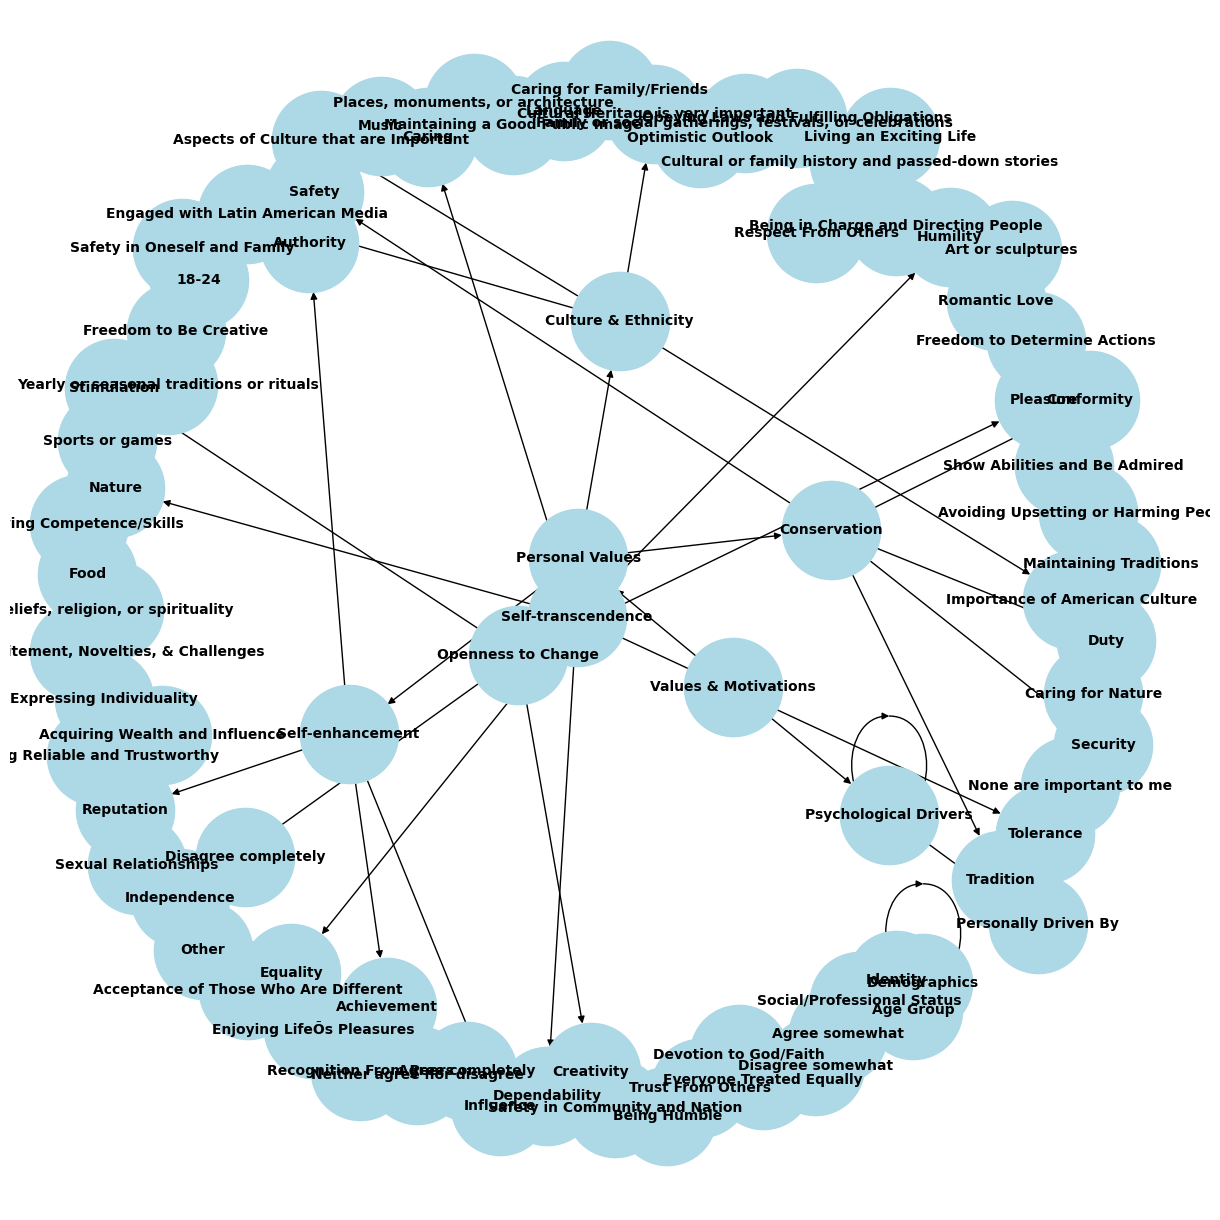

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame loaded from the CSV
df = pd.read_csv('raw_data.csv')
df = df.head(59) 

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on the DataFrame
for _, row in df.iterrows():
    category = row['Category']
    subcategory1 = row['Subcategory1']
    subcategory2 = row['Subcategory2']
    insight = row['Insight']
    insight_value = row['Insight Value']
    
    # Add nodes. If node already exists, it's ignored by networkx
    G.add_node(category, type='Category')
    G.add_node(subcategory1, type='Subcategory1')
    G.add_node(subcategory2, type='Subcategory2')
    G.add_node(insight, type='Insight')
    G.add_node(insight_value, type='Insight Value',
               composition=row['Composition (%)'], 
               index=row['Index'])
    
    # Add edges. If edge already exists, this is also ignored
    G.add_edge(category, subcategory1, relation='has subcategory')
    G.add_edge(subcategory1, subcategory2, relation='has subcategory')
    G.add_edge(subcategory2, insight, relation='has insight')

# Visualization (optional, can be skipped in environments without display capabilities)
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_size=5000, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()


In [2]:
from langchain.indexes import GraphIndexCreator
from langchain_openai import OpenAI
from langchain.indexes.graph import NetworkxEntityGraph

index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))

In [3]:
graph = NetworkxEntityGraph(G)
graph.get_number_of_nodes()

83

In [38]:
PG = nx.nx_pydot.to_pydot(graph)
H = nx.nx_pydot.from_pydot(PG)
nx.draw(H, with_labels=True)
plt.show()

AttributeError: 'NetworkxEntityGraph' object has no attribute 'is_directed'

In [26]:
from langchain.chains import GraphQAChain
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)

chain.invoke("Which are the motivators subcategories?")



> Entering new GraphQAChain chain...
Entities Extracted:
 NONE
Full Context:


> Finished chain.


{'query': 'Which are the motivators subcategories?',
 'result': "\nI don't know."}

In [24]:
list(graph.get_entity_knowledge("Creativity"))

NameError: name 'Creativity' is not defined

In [ ]:
# Example 1: List all Subcategory1 entries under the Category "Values & Motivations"
subcategory1_list = list(G.successors("Values & Motivations"))
print(subcategory1_list)

In [ ]:

# Example 2: Find the path from the Category "Values & Motivations" to the Insight "Creativity"
# Since paths in this kind of graph can be numerous, we'll find one path to the insight "Creativity" if it exists
path_to_creativity = None
for insight in G.nodes:
    if insight == "Creativity":
        path_to_creativity = nx.shortest_path(G, source="Values & Motivations", target=insight, method='dijkstra')
print(path_to_creativity)

In [ ]:
G.nodes()

In [ ]:

# Example 3: List all Insights under the Subcategory2 "Openness to Change"
insight_list = list(G.successors("Openness to Change"))

# Example 4: Check if "Openness to Change" is a subcategory of "Personal Values"
is_subcategory = ("Personal Values", "Openness to Change") in G.edges

(subcategory1_list, path_to_creativity, insight_list, is_subcategory)


In [ ]:
from langchain.indexes.graph import NetworkxEntityGraph

# Create a graph object
graph = NetworkxEntityGraph(G)

In [ ]:
graph.get_neighbors('Video Games')

In [ ]:
import langchain as lc
from langchain.chains import GraphQAChain
from langchain.graphs import NetworkxEntityGraph
from langchain.extraction import EntityExtractionChain

# Convert NetworkX graph to a dictionary format that can be used with LangChain
entity_graph_data = {}
for node in G.nodes():
    connected_nodes = list(G.successors(node))
    entity_graph_data[node] = {edge: {} for edge in connected_nodes}

# Initialize the entity graph
entity_graph = NetworkxEntityGraph(graph=G)

# Create a GraphChain for querying
# graph_chain = GraphQAChain(graph=entity_graph)
graph_chain = GraphQAChain(graph=entity_graph, entity_extraction_chain=lc.EntityExtractionChain(), qa_chain=lc.QAChain())

# Example query: "What falls under 'Personal Values'?"
response = graph_chain.invoke("What falls under 'Personal Values'?")
print(response)


In [ ]:
entity_graph_data

In [ ]:
from langchain.chains import GraphQAChain
from langchain_openai import OpenAI

chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)

In [ ]:
chain.invoke("What is the composition of the insight 'Stimulation'?")

In [ ]:
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-4-0125-preview")

# Convert the DataFrame to a string and then to a list of graph documents
documents = [Document(page_content=df.to_string())]

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Please use thematic analysis to identify key themes and suggest which insights might be semantically related.",
        ),
    ]
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_relationships=["IS_CORRELATED_WITH"],
    prompt=prompt,
)

In [ ]:

graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

In [ ]:
from langchain_openai import OpenAI
from langchain.chains import GraphQAChain

from langchain.graphs import NetworkxEntityGraph

# Convert the NetworkX graph to a NetworkxEntityGraph
entity_graph = NetworkxEntityGraph(graph_documents)

chain = GraphQAChain.from_llm(llm=llm, graph=entity_graph, verbose=True)

In [ ]:
from langchain_openai import OpenAI
from langchain.chains import GraphQAChain
# chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=G, verbose=True)

from langchain.graphs import NetworkxEntityGraph

# Convert the NetworkX graph to a NetworkxEntityGraph
entity_graph = NetworkxEntityGraph(G)

# Now use the entity_graph in the GraphQAChain
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=entity_graph, verbose=True)


In [ ]:
chain.run("What is the gender composition")

In [ ]:
entity_graph.get_triples()

In [ ]:
from langchain.indexes import GraphIndexCreator
from langchain_openai import OpenAI

index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))

In [ ]:
df.iloc[0, :]


In [ ]:
graph = index_creator.from_text(df)

In [ ]:
graph.get_triples()

In [ ]:
from langchain.chains import GraphQAChain

chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)

In [ ]:
chain.invoke("Values & Motivations")

In [ ]:
df = pd.read_csv('raw_data.csv')

G = nx.from_pandas_edgelist(df, source='Category', target='Insight')

In [ ]:
len(G.nodes())

In [ ]:
list(G.neighbors('Values & Motivations'))

In [ ]:
df['Insight'].unique()

In [ ]:
from langchain.graphs import NetworkxEntityGraph

# Convert the NetworkX graph to a NetworkxEntityGraph
entity_graph = NetworkxEntityGraph(G)

# Now use the entity_graph in the GraphQAChain
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=entity_graph, verbose=True)